### Building the AutoEncoder

In [1]:
#importing all the necessary Libraries
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

In [10]:
#configuration of the AutoEncoder
input_shape = (28, 28, 1)
chan_dim = -1
filters=(32, 64)
latent_dim=16
depth=1

#### Creating the Encoder

In [3]:
# Define the input to the encoder
inputs = Input(shape=input_shape)
x = inputs
# Loop over the number of filters
for f in filters:
    # Apply a CONV => RELU => BN operation
    x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=chan_dim)(x)

In [6]:
# Flatten the network and then construct the latent vector
x = Flatten()(x)
latent = Dense(latent_dim)(x)
# Build the encoder model
encoder = Model(inputs, latent, name="encoder")

In [7]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256 

#### Creating the Decoder

In [11]:
# Start the building to the decoder model which will accept the output of the encoder as its inputs
latent_inputs = Input(shape=(latent_dim,))
x = Dense(np.prod(volume_size[1:]))(latent_inputs)
x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
# Loop over the number of filters again, but this time in reverse order
for f in filters[::-1]:
    # Apply a CONV_TRANSPOSE => RELU => BN operation
    x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=chan_dim)(x)
# Apply a single CONV_TRANSPOSE layer used to recover the original depth of the image
x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
outputs = Activation("sigmoid")(x)
# Build the decoder model
decoder = Model(latent_inputs, outputs, name="decoder")

In [ ]:
decoder.summary()

#### The autoencoder is the encoder + decoder

In [12]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69392     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         109377    
Total params: 178,769
Trainable params: 178,385
Non-trainable params: 384
_________________________________________________________________


### Creating Image Denoiser by training Autoencoder created above

In [13]:
#importing necessary Libraries
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [14]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32
# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()
# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...


In [16]:
# sample noise from a random normal distribution centered at 0.5 (since
# our images lie in the range [0, 1]) and a standard deviation of 0.5
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

#### Training the AutoEncoder

In [17]:
print("[INFO] building autoencoder...")
opt = Adam(learning_rate=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)
# train the convolutional autoencoder
H = autoencoder.fit(
    trainXNoisy, trainX,
    validation_data=(testXNoisy, testX),
    epochs=EPOCHS,
    batch_size=BS)

[INFO] building autoencoder...


D:\Programming\Internships\Internship-Edlox\autoencoder-anomaly-detection\venv\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/25
1875/1875 [==============================] - 81s 42ms/step - loss: 0.0283 - val_loss: 0.0196
Epoch 2/25
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0188 - val_loss: 0.0182
Epoch 3/25
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0178 - val_loss: 0.0174
Epoch 4/25
1875/1875 [==============================] - 78s 41ms/step - loss: 0.0173 - val_loss: 0.0168
Epoch 5/25
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0168 - val_loss: 0.0172
Epoch 6/25
1875/1875 [==============================] - 78s 42ms/step - loss: 0.0165 - val_loss: 0.0171
Epoch 7/25
1875/1875 [==============================] - 78s 41ms/step - loss: 0.0163 - val_loss: 0.0168
Epoch 8/25
1875/1875 [==============================] - 80s 43ms/step - loss: 0.0161 - val_loss: 0.0163
Epoch 9/25
1875/1875 [==============================] - 77s 41ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 10/25
1875/1875 [==============================] - 78s 42m

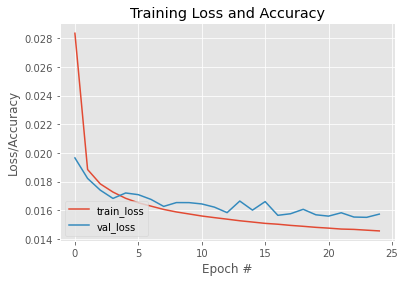

In [18]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png") #save the image

In [20]:
#saving the model
autoencoder.save("autoencoder.h5", save_format="h5")

In [21]:
#load the model
import tensorflow as tf
model = tf.keras.models.load_model("autoencoder.h5")

(-0.5, 27.5, 27.5, -0.5)

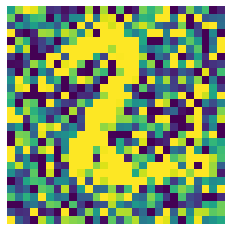

In [128]:
plt.imshow((testXNoisy[1]*255).astype("uint8"))
plt.axis('off')
# plt.savefig("test.png", bbox_inches='tight',transparent=True)

In [134]:
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testXNoisy)
outputs = None
# loop over our number of output samples
for i in range(0, 8):
    # grab the original image and reconstructed image
    original = (testXNoisy[i] * 255).astype("uint8")
    recon = (decoded[i] * 255).astype("uint8")
    # stack the original and reconstructed image side-by-side
    output = np.hstack([original, recon])
    # if the outputs array is empty, initialize it as the current
    # side-by-side image display
    if outputs is None:
        outputs = output
    # otherwise, vertically stack the outputs
    else:
        outputs = np.vstack([outputs, output])
# save the outputs image to disk
cv2.imwrite("prediction.png", outputs)

[INFO] making predictions...


True